#Data Processing

In [ ]:
import pandas as pd
from matplotlib import pyplot
df = pd.read_csv('^NSEI.csv')

In [ ]:
df['Change'] = df['Close'].diff()
df.drop('Adj Close',axis=1,inplace=True)
display(df.head())
display(df.tail())
print('Columns are ',df.columns)
print('No. of entries ',len(df))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Volume,Change
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,0.0,NaN
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,0.0,45.699707
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,0.0,3.899903
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,0.0,-18.699707
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,0.0,-18.350098


,Date,Open,High,Low,Close,Volume,Change
2341,2019-06-24,11725.799805,11754.000000,11670.200195,11699.650391,277600.0,-24.449218
2342,2019-06-25,11681.000000,11814.400391,11651.000000,11796.450195,300500.0,96.799804
2343,2019-06-26,11768.150391,11871.849609,11757.549805,11847.549805,327900.0,51.099610
2344,2019-06-27,11860.849609,11911.150391,11821.049805,11841.549805,480200.0,-6.000000
2345,2019-06-28,11861.150391,11871.700195,11775.500000,11788.849609,303900.0,-52.700196


Columns are  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')
No. of entries  2346


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


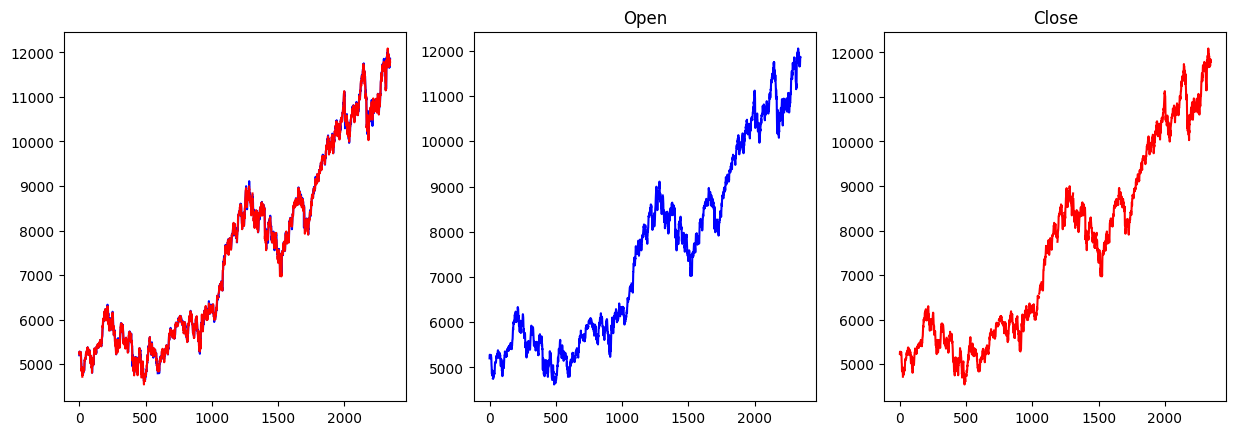

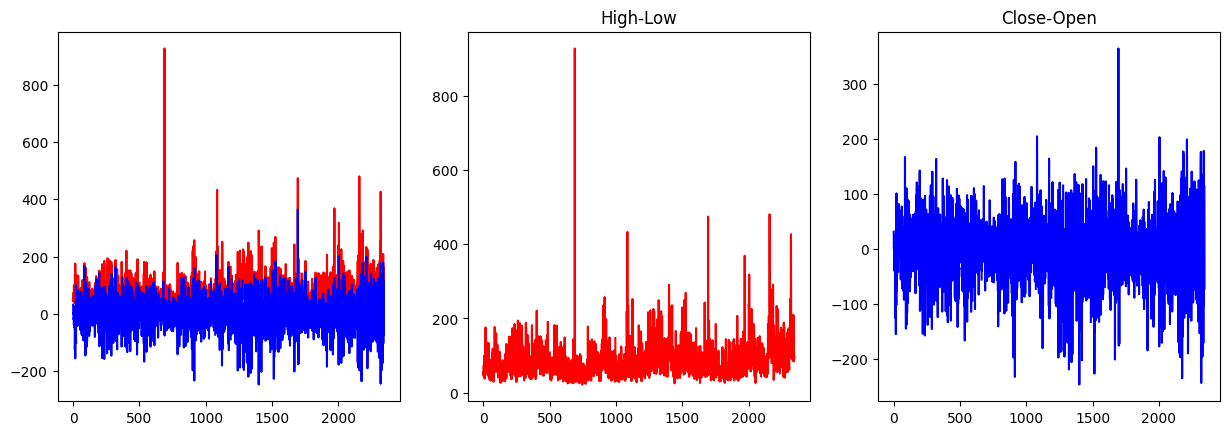

In [ ]:
fig,ax = pyplot.subplots(1,3)
fig.set_figwidth(15)
ax[0].plot(df['Open'],color='blue')
ax[0].plot(df['Close'],color='red')
ax[1].plot(df['Open'],color='blue')
ax[1].set_title('Open')
ax[2].plot(df['Close'],color='red')
ax[2].set_title('Close')
pyplot.show()
fig,ax = pyplot.subplots(1,3)
fig.set_figwidth(15)
ax[0].plot(df['High']-df['Low'],color='red')
ax[0].plot(df['Close']-df['Open'],color='blue')
ax[1].plot(df['High']-df['Low'],color='red')
ax[2].plot(df['Close']-df['Open'],color='blue')
ax[1].set_title('High-Low')
ax[2].set_title('Close-Open')
pyplot.show()

#RL Environment




In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [ ]:
class Actions(Enum):
    Sell = 0
    Buy = 1

class Positions(Enum):
    Short = 0
    Long = 1
    def invert(self):
        return Positions.Short if self == Positions.Long else Positions.Long

class TradingEnv(gym.Env):

    def __init__(self, df, window_size,start,stop):

        assert start>=window_size
        self.df = df
        self.window_size = window_size
        self.frame = (start,stop)
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._total_reward = None
        self._total_profit = None

    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._total_reward = 0.
        self._total_profit = 1.
        return self._get_observation()

    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.invert()
            self._last_trade_tick = self._current_tick

        observation = self._get_observation()
        data = {'total_reward': self._total_reward,'total_profit': self._total_profit,'position': self._position.value}

        return observation, step_reward, self._done, data

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _process_data(self):
        prices = self.df['Close'].to_numpy()

        prices[self.frame[0] - self.window_size]
        prices = prices[self.frame[0]-self.window_size:self.frame[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = df[['Open','High','Low','Close','Volume','Change']].loc[self.frame[0]-self.window_size:self.frame[1]].to_numpy()

        return prices, signal_features

    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            if self._position == Positions.Long:
                step_reward += current_price - last_trade_price

        return step_reward

    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                self._total_profit = self._total_profit / last_trade_price * current_price


In [ ]:
env = TradingEnv(df,30,30,len(df)-1)